In [1]:
import os
from os.path import isdir, join
from scipy.io import wavfile
from subprocess import check_output
from pathlib import Path
import pandas as pd


# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import IPython
import seaborn as sns
import IPython.display as ipd
import librosa.display
from pydub import AudioSegment
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

C:\Users\goeld\AppData\Local\Programs\Python\Python37\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
train_dir = r'D:\Speech Recognition Dataset\train\audio'

In [3]:
data_dist = {}
audio = {}
for curr_label in os.listdir(train_dir):
    data_dist[curr_label] = 0
    curr_audios = []
    for file in os.listdir(train_dir + '\\' + curr_label):
        data_dist[curr_label] = data_dist[curr_label]+1
        curr_audios.append(train_dir + '\\' + curr_label + '\\' + file)
    audio[curr_label] = curr_audios

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'NOISE', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
[1713, 1731, 1733, 1746, 2359, 2352, 2357, 2372, 2372, 1742, 1750, 2353, 1746, 2364, 2375, 1398, 2357, 2367, 2370, 2367, 2377, 1734, 2369, 2380, 2356, 1733, 2373, 2375, 1745, 2377, 2376]


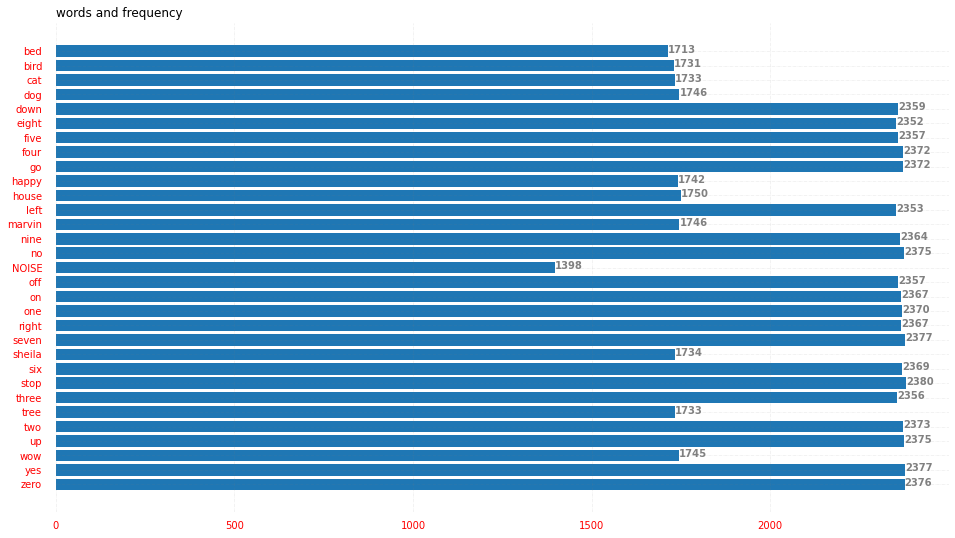

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
 
 
words = list(data_dist.keys())
print(words)
freq = list(data_dist.values())
print(freq)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(words, freq)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('words and frequency',
             loc ='left')
 
 
# Show Plot
plt.show()

In [41]:
x, sr = librosa.load(audio['bed'][1] , 16000)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(16000,) 16000


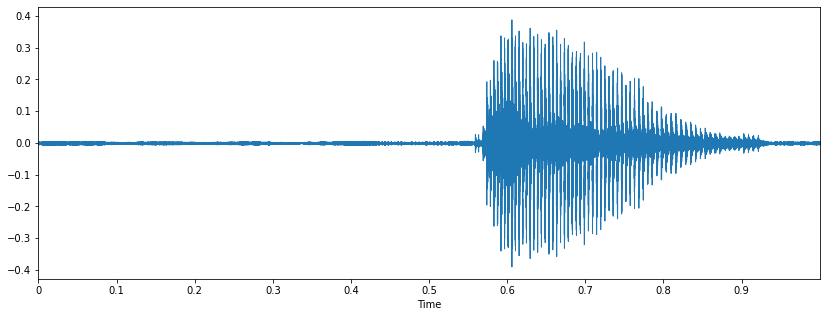

In [42]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [43]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio

In [44]:
import tensorflow as tf

In [45]:
DATASET_ROOT = r'D:\Speech Recognition Dataset\train'
NOISE_SUBFOLDER = "_background_noise_"
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)
SAMPLING_RATE = 16000
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    if subdir != 'README.md':
        subdir_path = DATASET_NOISE_PATH + '\\' + subdir
        noise_paths.append(subdir_path)
noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)
noises = np.array(noises)

In [46]:
noises.shape

(398, 16000, 1)

In [48]:
x = x.reshape([16000,1])

In [49]:
x.shape

(16000, 1)

In [56]:
noisy_x = np.array(x) + 0.5 * noises[1]

In [57]:
noisy_x=noisy_x.reshape([16000,])

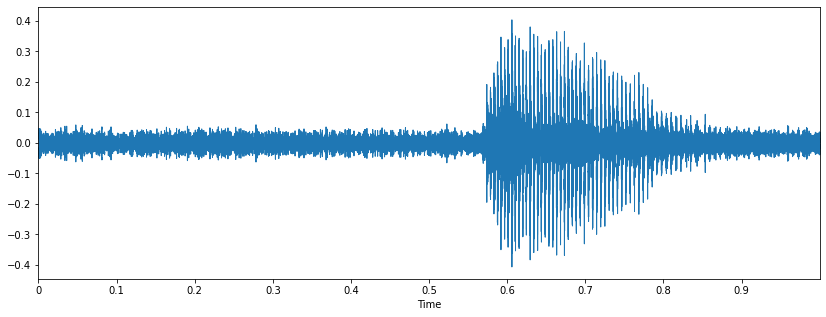

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noisy_x, sr=sr)

In [59]:
_FFT_SIZE = 1024
_HOP_SIZE = 512
_N_MEL_BINS = 128
_N_SPECTROGRAM_BINS = (_FFT_SIZE // 2) + 1
_F_MIN = 0.0
_F_MAX = SAMPLING_RATE / 2

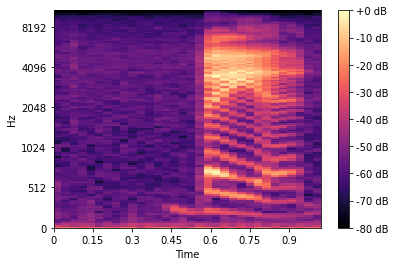

In [63]:
S = librosa.feature.melspectrogram(x.reshape([16000,]), sr=16000, n_fft=1024, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=16000, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB')

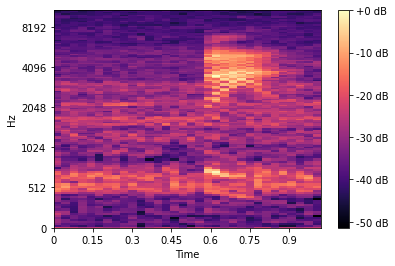

In [64]:
S = librosa.feature.melspectrogram(noisy_x.reshape([16000,]), sr=16000, n_fft=1024, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=16000, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB')

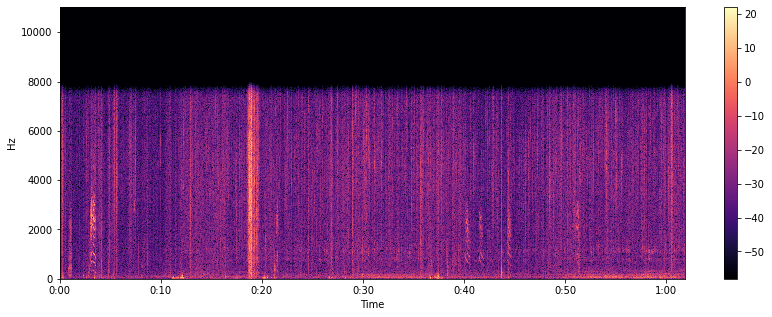

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [23]:
IPython.display.Audio(audio['bed'][1])

In [27]:
x, sr = librosa.load(audio['down'][8])
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(22050,) 22050


In [32]:
s = []
for a in audio:
    if a != '_background_noise_':
        for i in range(len(audio[a])):
            x, sr = librosa.load(audio[a][i])
            s.append(x)
set(s)

KeyboardInterrupt: 

In [38]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from tdutils import *
%matplotlib inline

In [34]:
k = []
for x in s:
    k.append(len(x))

In [35]:
set(k)

{8193,
 8468,
 9217,
 9409,
 10115,
 10241,
 10350,
 10820,
 11056,
 11265,
 11290,
 11526,
 11761,
 12231,
 12289,
 12467,
 12937,
 13173,
 13313,
 13407,
 13643,
 13826,
 13878,
 14112,
 14337,
 14348,
 14584,
 14818,
 15054,
 15289,
 15361,
 15524,
 15759,
 15876,
 15995,
 16229,
 16385,
 16465,
 16701,
 16898,
 16935,
 17171,
 17199,
 17406,
 17409,
 17640,
 17876,
 18112,
 18346,
 18433,
 18582,
 18817,
 19052,
 19287,
 19457,
 19523,
 19757,
 19970,
 19993,
 20229,
 20463,
 20481,
 20699,
 20883,
 20934,
 20993,
 21168,
 21324,
 21404,
 21505,
 21640,
 21765,
 21874,
 22017,
 22050}

In [40]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [65]:
len(data_dist.keys())

31

C:\Users\goeld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: WavFileWarning:

Chunk (non-data) not understood, skipping it.



'D:\\Speech Recognition Dataset\\train\\audio\\_background_noise_\\dude_miaowing.wav'